In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import shutil

# Custom functions
import fpm_functions as fpm

 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction Done!
 Reconstruction Progress: 100%
 Reconstruction

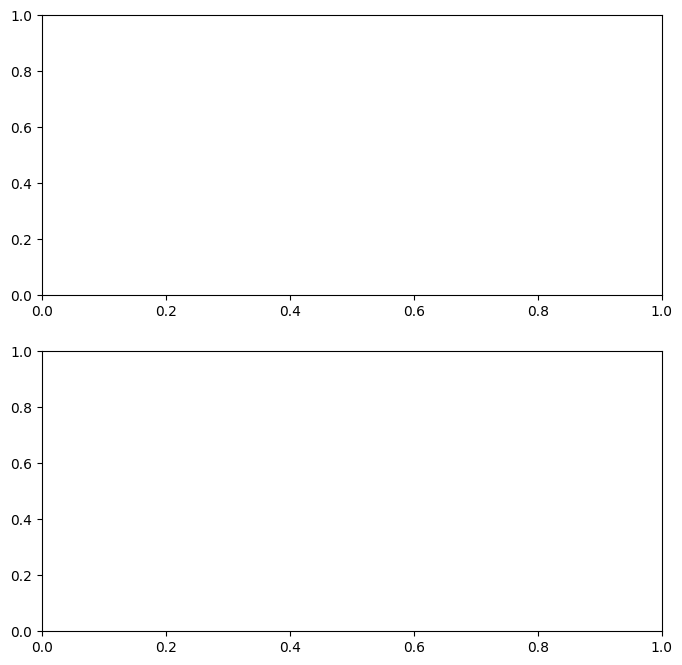

In [6]:
import importlib 
importlib.reload(fpm)

# Load image data into an array
data_path = 'data/library/talia_full_frame_2'
grid_size = 15 # 1 -> 16, determines how many images to reconstruct with
img_size = 100
crop_x = 800 # From left
crop_y = 500 # From top
# crop_x=crop_y=0
# img_size = 300

remove_edge_NA = True # Remove images on edge of brightfield
edge_NA = [9,10,11,12,13,16,17,18,19] # Images in the dataset which are half brightfield half darkfield 

fig,axes = plt.subplots(2, 1, figsize=(8,8))

num_images = grid_size**2
images = np.zeros((img_size,img_size,num_images)) # Initialise array for storing images
brightfield = np.array(Image.open(os.path.join(data_path,'brightfield.png')))/256 # Brightfield image for reference
brightfield = brightfield[crop_y:crop_y+img_size,crop_x:crop_x+img_size] # Crop

for i in range(num_images): # ~ 2s to load all 256 images into array
    filename = os.path.join(data_path, f'image_{i}.png') # Construct path
    img = np.array(Image.open(filename))/255 # Open image and scale range to 0-1
    img = img[crop_y:crop_y+img_size,crop_x:crop_x+img_size] # Crop
    images[:,:,i] = img
    
# Remove half bf half df images at edge of NA
if remove_edge_NA:
    images = np.delete(images,edge_NA,axis=2)
    
# LED sequence
x_coords, y_coords = fpm.LED_spiral(grid_size)

# # Original parameter values (expected)
# led2sample = 80 # Distance from LED array to the sample, (shorter distance leads to closer overlapping Fourier circles)
# led_pitch = 3.3 # LED pitch, 3.3mm
# numerical_aperture = 0.1 # Objective numerical aperture, 0.1
# pix_size = 1025e-9 # Pixel size on object plane, m, 1025nm for 3D printed microscope (directly measured)
# wlength = 550e-9 # Central wavelength of LED light, m, 550nm for white, 630nm for red, 460nm for blue
# x_initial = 0 # x distance from first LED to optical axis, mm (+ve if first LED is to right of optical axis)
# y_initial = 0 # y distance from first LED to optical axis, mm (+ve if first LED is below optical axis)

# Adjusted optical parameters (sensitivity testing)
# The main parameters to test are the led2sample and x_initial,y_initial
# Ensure pixel_size is correct (can be measured in quality_analysis on USAF)

led2sample = 73
x_initial = 0.9
y_initial = -0.5
led_pitch = 3.3
numerical_aperture = 0.1
pix_size = 725e-9
wlength = 550e-9


# Helper function
def create_array(center, percentage, num_points):
    lower_limit = center * (1 - percentage / 100)
    upper_limit = center * (1 + percentage / 100)
    return np.linspace(lower_limit,upper_limit,num_points)

# Arrays for test values
num_points = 6 # Number of values to try for each parameter
percentage = 5 # Range to search (e.g. do once with 30 and once with 10, 20 points for each)

# Single parameter tests
led2sample_array = create_array(led2sample, percentage, num_points)
led_pitch_array = create_array(led_pitch, percentage, num_points)
numerical_aperture_array = create_array(numerical_aperture, percentage, num_points)
pix_size_array = create_array(pix_size, percentage, num_points)
wlength_array = create_array(wlength, percentage, num_points)

# Initial x,y parameter tests
search_range = 1
x_initial_array = np.linspace(x_initial-search_range,x_initial+search_range,num_points)
y_initial_array = np.linspace(y_initial-search_range,y_initial+search_range,num_points)

def create_empty_folder(folder_path):
    # If the folder already exists, delete it and its contents
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)  # Recursively delete folder and its contents
    # Create a new, empty folder
    os.makedirs(folder_path)

# Specify the folder path
output_folder = 'results/testing/general'

# Create or overwrite the folder
create_empty_folder(output_folder)

for j in range(num_points): # Set this loop to 1 for single dimension array
    for i in range(num_points): # Double loop for x,y initial search
        # # Test parameter
        # led2sample = led2sample_array[i]
        # img_name = f'{round(led2sample,2)}.png'
        
        # led_pitch = led_pitch_array[i]
        # img_name = f'{round(led_pitch,2)}.png'
        
        # numerical_aperture = numerical_aperture_array[i]
        # img_name = f'{round(numerical_aperture,3)}.png'

        # pix_size = pix_size_array[i]
        # img_name = f'{round(pix_size*10**9)}.png'
        
        # wlength = wlength_array[i]
        # img_name = f'{round(wlength*10**9)}.png'
        
        x_initial = x_initial_array[i]
        y_initial = y_initial_array[j]
        img_name = f'{round(x_initial,2)},{round(y_initial,2)}.png'
       
        

        # Derived variables
        f_cutoff = 2*numerical_aperture/wlength # Highest spatial frequency we can resolve in the optical system due to diffraction, lp/m
        f_sampling = 1/pix_size # Sampling frequency (based on sensor pixel size and magnification), lp/m
        # Nyquist sampling criterion: sampling_ratio >2 -> oversampling (good), sampling_ratio <2 -> undersampling (aliasing may occur)
        sampling_ratio = f_sampling / f_cutoff # Ensure above 2
        # print(f'Sampling ratio: {SAMPLING_RATIO}')
        sampling_size = 1/(img_size*pix_size) # Distance between discrete points in the Fourier domain (used to scale wavevectors for indexing)
        x_abs = (x_coords - x_coords[0]) * led_pitch + x_initial # x distances of LEDs from optical axis, mm
        y_abs = (y_coords - y_coords[0]) * led_pitch + y_initial # y distances 

        # Size of reconstructed image (for given parameters upsampling is between 2 and 5 depending on grid_size)
        # Can do seperately x and y if image is not square
        # upsampling_ratio = fpm.calculate_upsampling_ratio(img_size, grid_size, led2sample, led_pitch, numerical_aperture, wlength, sampling_size)
        upsampling_ratio = 3 # Or can use a set value
        obj_size = upsampling_ratio * img_size

        # LED wavevectors - scaled for use in Fourier domain. To get true wavevectors multiply by sampling size
        kx,ky = fpm.calculate_wavevectors(x_abs, y_abs, led2sample, wlength, sampling_size)
        
        # Remove half bf half df images at edge of NA
        if remove_edge_NA:
            kx = np.delete(kx,edge_NA)
            ky = np.delete(ky,edge_NA)

        # Initial pupil function (binary mask)
        # x,y is our normalised frequency domain for the images, cutoff frequency = 1 (both x and y)
        x,y = np.meshgrid(np.linspace(-sampling_ratio,sampling_ratio,img_size), np.linspace(-sampling_ratio,sampling_ratio,img_size))
        theta,r = np.arctan2(y,x), np.sqrt(x**2 + y**2) # Polar coordinates
        pupil_radius = (1/sampling_ratio) * (img_size/2) # In pixels
        pupil_binary = r<1 # Binary mask for frequencies below cutoff frequency (higher frequencies cannot be resolved due to diffraction)

        # Initial object estimate (using central image or brightfield)
        img = np.sqrt(images[:,:,0]) # Amplitude of central image
        # img = np.sqrt(brightfield) # Amplitude of brightfield
        F_img = fpm.FT(img) # Fourier transformed image
        F_img = F_img * pupil_binary # Apply pupil function
        pad_width = int((obj_size - img_size) / 2) # Padding to make correct size
        obj = np.pad(F_img,pad_width,'constant',constant_values=0) # Initial object in frequency domain

        # Create fig and axes for plotting
        # fig, axes = plt.subplots(1,3,figsize=(15,4))

        # Set parameters for reconstruction algorithm
        options = {
            'max_iter': 5, # Number of iterations
            'alpha': 1, # Regularisation parameter for object update, <10
            'beta': 1, # Regularisation parameter for pupil update, >1
            'plot_mode': 0, # 0, off; 2, plot every image; 3, plot every iteration (notebook version)
            'LED_correction': 0, # 0, off; 1, accurate; 2, fast. Update wavevectors during reconstruction 
            'update_method': 2, # 1, PIE; 2, ePIE; 3, rPIE
            'momentum': True, # Use momentum on alpha and beta (tuned for ePIE only)
            'intensity_correction': True
        }

        # Reconstruction with calculated kx and ky (quickstart)
        rec_obj,rec_pupil,kx_updated,ky_updated = fpm.reconstruct(images, kx, ky, obj, pupil_binary, options, fig, axes, pupil=None)

        obj_mag = np.abs(rec_obj)
        obj_mag = obj_mag / np.max(obj_mag) # Normalise
        obj_mag = (obj_mag * 255).astype(np.uint8)
        obj_mag = Image.fromarray(obj_mag)
        obj_mag.save(os.path.join(output_folder,img_name))

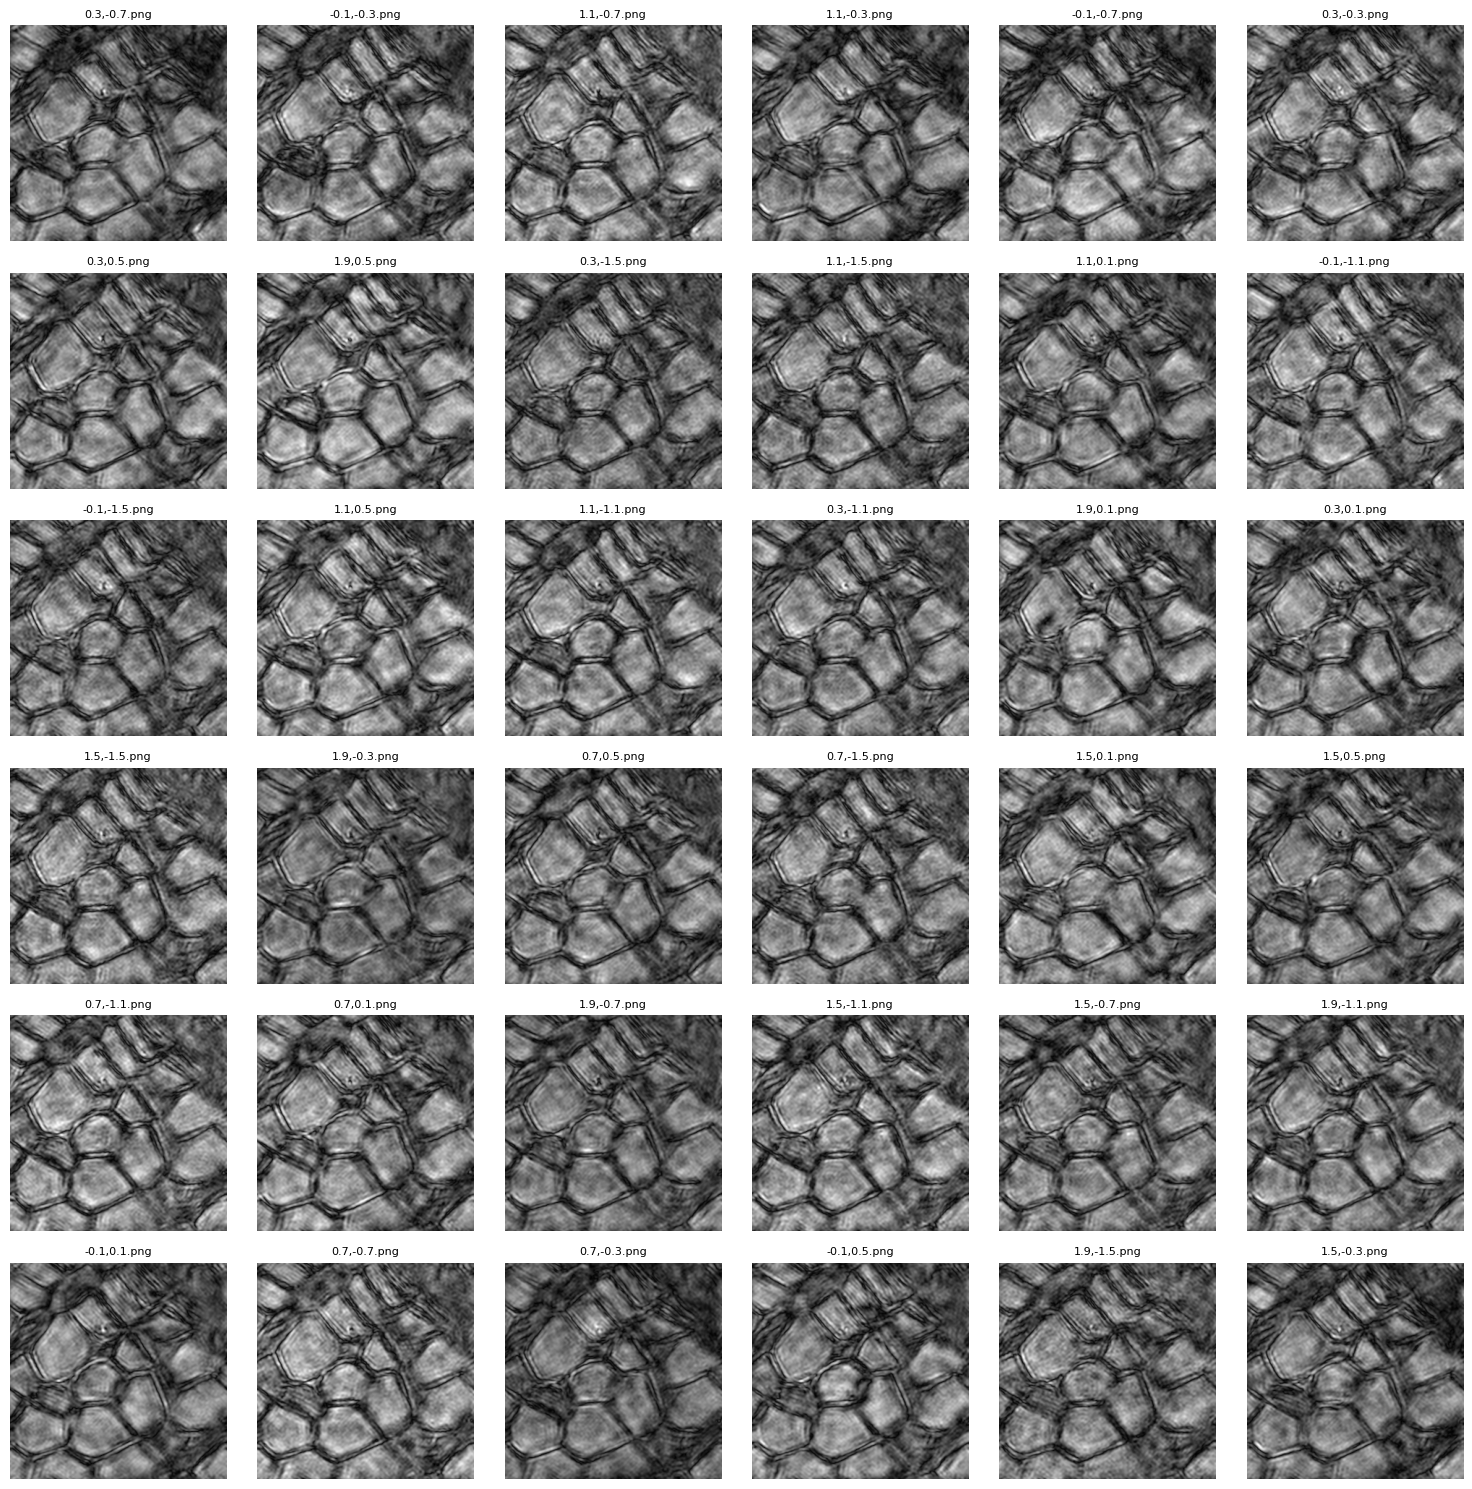

In [7]:
# Visualise data
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np

# Specify the folder containing the PNG images
# output_folder = 'results/testing/WLENGTH'

# Get a list of all PNG files in the folder
image_files = [f for f in os.listdir(output_folder) if f.endswith('.png')]

# # Sort the files numerically by extracting the numeric part of the filename
# def extract_number(filename):
#     return float(filename.split('.png')[0])  # Extract the number before '.png'
# image_files.sort(key=extract_number)

# Determine the grid size (rows and columns)
num_images = len(image_files)
grid_size = int(np.ceil(np.sqrt(num_images)))  # Create a square grid

# Set up the figure size
plt.figure(figsize=(15, 15))

# Loop through each image and plot it
for idx, image_file in enumerate(image_files):
    # Load the image
    img_path = os.path.join(output_folder, image_file)
    img = mpimg.imread(img_path)
    
    # Add a subplot for this image
    plt.subplot(grid_size, grid_size, idx + 1)
    plt.imshow(img, cmap='gray')  # Use 'gray' for grayscale images
    plt.axis('off')  # Turn off the axis
    plt.title(image_file, fontsize=8)  # Optionally display the filename

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()
